# Machine Learning in Python - Project 2

Due Friday, April 12th by 4 pm.

*Massimo Wu, Qinqing Li, Emily Qiu*

## Setup

*Install any packages here and load data*

In [3]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np
import os
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, balanced_accuracy_score, log_loss, recall_score, precision_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImPipeline
from scipy.stats.distributions import uniform, loguniform

from sklearn.dummy import DummyClassifier
from joblib import dump, load

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', message='Found unknown categories')
# when running logistic CV
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Setting penalty='none' will ignore the C and l1_ratio parameters")
warnings.filterwarnings("ignore", message="l1_ratio parameter is only used when penalty is 'elasticnet'")

In [4]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,zipcode,id_loan,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,prepaid,default
0,709.0,201703,9,204702,NaN,12,1,P,84,26,...,51300,F117Q1000376,N,360,2,Other sellers,Other servicers,NaN,0,1
1,649.0,201703,9,203202,33124.0,0,1,P,52,22,...,33100,F117Q1000418,C,180,2,Other sellers,Other servicers,NaN,1,0
2,747.0,201703,9,203702,41180.0,0,1,I,43,20,...,63100,F117Q1000479,N,240,2,Other sellers,Other servicers,NaN,1,0
3,711.0,201703,9,204702,20260.0,0,1,I,80,21,...,55800,F117Q1000523,P,360,2,Other sellers,Other servicers,NaN,1,0
4,751.0,201703,N,204702,NaN,35,1,P,95,24,...,75900,F117Q1000719,P,360,1,Other sellers,ARVESTCENTRALMTGECO,NaN,1,0


# Introduction

Due to the significant costs associated with mortgage defaults for all parties involved, including mortgage lenders, mortgagors, investors of mortgage-backed securities (MBS), and MBS guarantors, assessing and managing default risk is a crucial concern for financial institutions and policymakers. Our objective is to develop the optimal model for predicting mortgage defaults using data provided by Freddie Mac.

Our model selection process involved comparing various algorithms including Logistic Regression, Random Forest, Support Vector Classifier, and Gradient Boosting models. The baseline model assumes no defaults. We used grid search to optimise hyperparameters for each model and applied Cross Validation (CV) and oversampling techniques.

The Gradient Boost with Oversampling and 5-fold CV come out as the most effective in predicting False Negatives, prioritising recall score. Using feature importance plot, key features in descending order include: first-time home buyer, date of last payment, date of first payment, loan ID, and MSA area code. Other features were deemed insignificant.

# Exploratory Data Analysis and Feature Engineering

**variable summary**
| Variable Type      | Variable Name  | Description                                                                                                                                                                       |
|--------------------|----------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Numerical          | fico           | Credit score.                                                                                                                                                                     |
| Categorical        | dt_first_pi    | Date of the first mortgage payment, in the format YYYYMM, ranging from 2017 to 2019.                                                                                             |
| Categorical        | dt_matr        | Maturity date, date of the last mortgage payment, in the format YYYYMM, ranging from 202504 to 204812.                                                                           |
| Binary             | flag_fthb      | First-time homebuyer flag, with missing value encoded with 9.                                                                                                                    |
| Numerical          | orig_upb       | Loan amount that has not yet been paid off.                                                                                                                                      |
| Numerical          | int_rt         | Interest rate of the loan.                                                                                                                                                       |
| Identifier         | cd_msa         | they are 5-digit codes of Metropolitan Statistical Area (MSA) regions in the US, where the complete list of encodings can be found in this [document](https://www2.census.gov/programs-surveys/cps/methodology/Geographic%20Coding%20-%20Metro%20Areas%20(since%20August%202005).pdf). |
| Categorical        | mi_pct         | percentage of the loan amount that's required for mortgage insurance. It is often required when the borrower's down payment on a home is less than a certain percentage of the home's purchase price.) It's classified as categorical because only there's only 7 insurance levels:  0,6,12,20,25,30,35.|
| Categorical        | cnt_units      | Number of units in the mortgaged property, with 4 levels: 1, 2, 3, 4.                                                                                                            |
| Categorical        | occpy_sts      | Mortgage type, with 3 levels: owner-occupied (P), second home (S), or investment property (I).                                                                                  |
| Numerical          | cltv           | Rate of loan amount to total property value.                                                                                                                                     |
| Numerical          | dti            | Debt-to-income ratio, calculated by monthly housing expenses divided by the monthly income used to underwrite the loan.                                                         |
| Numerical          | ltv            | For example, if a borrower takes out a mortgage for £150,000 to purchase a home that is appraised at £$200,000$, the original loan-to-value ratio would be $\frac{150,000}{200,000} = 0.75$, or $75\%$. This means that the borrower is financing $75\%$ of the property's value with the mortgage loan, and the remaining $25\%$ is covered by the borrower's down payment or equity.|
| Numerical          | int_rt         | Interest rate of the property.                                                                                                                                                   |
| Categorical        | channel        | Channel through which the mortgage was obtained.                                                                                                                                 |
| Binary             | ppmt_pnlty     | Penalty applied for prepayment, with 'Yes' or 'No' instances.                                                                                                                     |
| Binary             | prod_type      | Product type, with only fixed-rate mortgages in this dataset.                                                                                                                    |
| Categorical        | st             | US states, represented by two-letter abbreviations.                                                                                                                              |
| Categorical        | prop_type      | Property type: condominium (CO), planned unit development (PU), cooperative share (CP), manufactured home (MH), or single-family home (SF).                                     |
| Identifier         | zipcode        | 5-digit codes representing zip codes.                                                                                                                                             |
| Identifier         | id_loan        | Unique ID for each entry.                                                                                                                                                         |
| Categorical        | loan_purpose   | Purpose of the loan: Cash-out Refinance mortgage (C), No Cash-out Refinance mortgage (N), Refinance mortgage not specified (R), or a Purchase mortgage (P).                 |
| Numerical          | orig_loan_term | Number of monthly payments from the first payment until maturity date.                                                                                                           |
| Binary             | cnt_borr       | Number of borrower(s) obligated to pay the mortgage, with '1' indicating one borrower and '2' indicating more than one borrower.                                                  |
| Categorical        | seller_name    | Names of sellers of mortgages.                                                                                                                                                   |
| Categorical        | servicer_name  | Names of servicers of mortgages.                                                                                                                                                 |
| Binary             | flag_sc        | Flag indicating whether entries have 'Y' or NaN values.                                                                                                                          |
| Binary             | default        | Response variable indicating default, with '1' representing default and '0' representing no default.                                                                             |


**Missing value analysis** 

| No. of Missing | Variable Name | Explanation                                                                                                                                                         |
|----------------|---------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1              | fico          | Credit score.                                                                                                                                                       |
| 3468           | flag_fthb     | Binary variable indicating first-time homebuyer status.                                                                                                            |
| 594            | cd_msa        | (metropolitan statistical area), indicating $594$ mortgaged properties are either not in a Metropolitan Area or MSA status unknown; status.                                                                                                                         |
| 1              | cltv          | Rate of loan amount to total property value.                                                                                                                         |
| 1              | dti           | indicating $1$ impossible value of $>65\%$|
| 1              | ltv           | Loan-to-value ratio|
| 38             | ppmt_pnlty    | Binary variable indicating whether a prepayment penalty is applied.                                                                                                 |
| 5751           | flag_sc       |Binary variable flagging entries with either 'Y' or missing values.                                                                                                 |

In [40]:
missing_values_count = d.isnull().sum()
missing_values_table = pd.DataFrame({'Missing Values': missing_values_count})

print("Table of Null Values in Each Variable:")
print(missing_values_table)
count_9999 = d['fico'].astype(str).str.count('9999').sum()
print("Number of NA (encoded as 9999) in 'fico':", count_9999)
count_9 = d['flag_fthb'].astype(str).str.count('9').sum()
print("Number of NA (encoded as 9) in 'flag_fthb':", count_9)
count_999 = d['mi_pct'].astype(str).str.count('999').sum()
print("Number of NA (999) in 'mi_pct':", count_999)
count_99 = d['cnt_units'].astype(str).str.count('99').sum()
print("Number of no information (99) in 'cnt_units':", count_99)
c9 = d['occpy_sts'].astype(str).str.count('9').sum()
print("Number of no information (9) in 'occpy_sts':", c9)
c999 = d['cltv'].astype(str).str.count('999').sum()
print("Number of no information (999) in 'cltv':", c999)
c_999 = d['dti'].astype(str).str.count('999').sum()
print("Number of NA (999) in 'dti':", c_999)
co_999 = d['ltv'].astype(str).str.count('999').sum()
print("Number of NA (999) in 'ltv':", co_999)
co_9 = d['channel'].astype(str).str.count('9').sum()
print("Number of NA (9) in 'channel':", co_9)
co_99 = d['prop_type'].astype(str).str.count('99').sum()
print("Number of NA (99) in 'prop_type':", co_99)
c_00 = d['zipcode'].astype(str).str.count('###00').sum()
print("Number of NA in 'zipcode':", c_00)
cou_9 = d['loan_purpose'].astype(str).str.count('9').sum()
print("Number of NA in 'loan_purpose':", cou_9)

Table of Null Values in Each Variable:
                Missing Values
fico                         1
dt_first_pi                  0
flag_fthb                    0
dt_matr                      0
cd_msa                     594
mi_pct                       0
cnt_units                    0
occpy_sts                    0
cltv                         0
dti                          0
orig_upb                     0
ltv                          0
int_rt                       0
channel                      0
ppmt_pnlty                  38
prod_type                    0
st                           0
prop_type                    0
zipcode                      0
id_loan                      0
loan_purpose                 0
orig_loan_term               0
cnt_borr                     0
seller_name                  0
servicer_name                0
flag_sc                   5751
prepaid                      0
default                      0
Number of NA (encoded as 9999) in 'fico': 0
Number of NA (enco

**Training and testing data split**: $90\%$ and $10\%$ of the data are allocated to training and testing dataset, respectively.

In [5]:
X = d.drop(columns=['default'])
y = d['default']  # Response variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

**Numerical variables**: the density plots, boxplots, heatmap and scatterplots of all continuous numerical variables.

In [6]:
# filter NA coded as 999

filtered_idx = X_train[(X_train['cltv'] != 999) & (X_train['dti'] != 999)].index
X_train_clean = X_train.loc[filtered_idx]
y_train_clean = y_train.loc[filtered_idx]

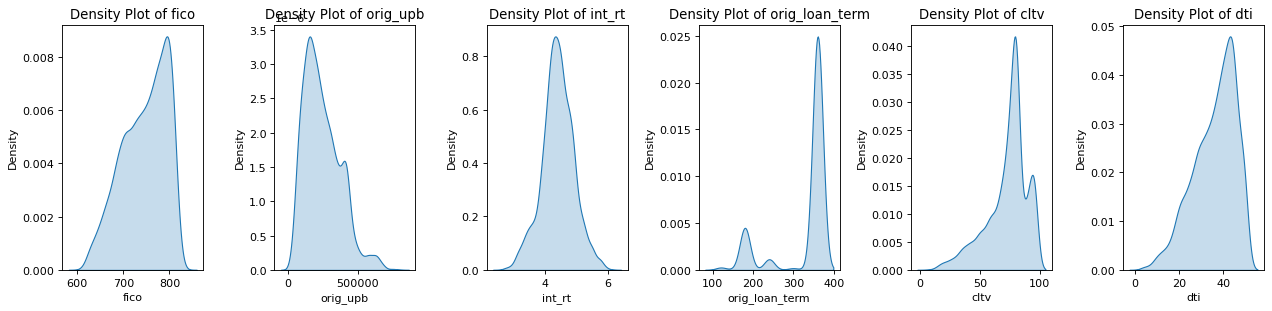

In [41]:
# filter NA coded as 999
#filtered_cltv = X_train[X_train['cltv'] != 999]['cltv']
#filtered_dti = X_train[X_train['dti'] != 999]['dti']
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16, 4))

# Numerical variables
num_var = ['fico', 'orig_upb', 'int_rt','orig_loan_term','cltv','dti']
for i, variable in enumerate(num_var):
    sns.kdeplot(data=X_train_clean[variable], ax=axes[i], fill=True)
    
    axes[i].set_title(f'Density Plot of {variable}')

plt.tight_layout()
plt.show()

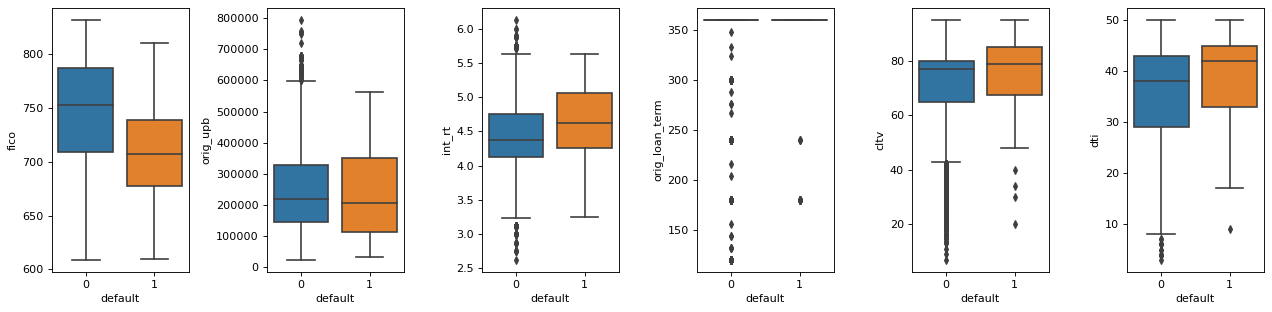

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16, 4))

# Looping through the numerical variables and creating the boxplots
for i, var in enumerate(num_var):
    sns.boxplot(x=y_train_clean, y=X_train_clean[var], ax=axes[i])

# Displaying the plot
plt.tight_layout()
plt.show()

most of observations in 'orig_loan_term' are = 360. Very few observations (and defaults) for others consider deleting them.

In [43]:
# set na
for column in X_train_clean[num_var].columns:
    Q1 = X_train_clean[num_var][column].quantile(0.25)
    Q3 = X_train_clean[num_var][column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_idx = X_train_clean[(X_train_clean[column] >= lower_bound) & (X_train_clean[column] <= upper_bound)].index
    X_train_clean = X_train_clean.loc[filtered_idx]
    y_train_clean = y_train_clean.loc[filtered_idx]
    
    #d[column] = d[num_var][column].mask((d[num_var][column] < lower_bound) | (d[num_var][column] > upper_bound), np.nan)

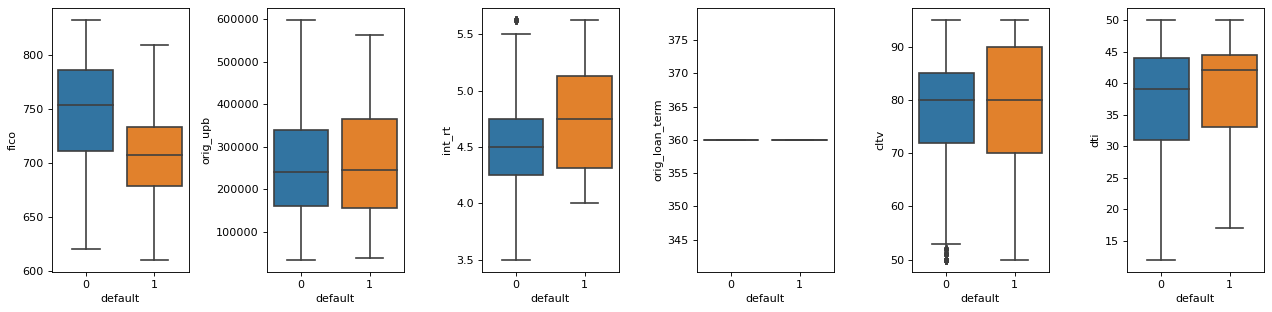

In [44]:
# boxplot after filtering iqr 
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16, 4))

for i, var in enumerate(num_var):
    sns.boxplot(x=y_train_clean, y=X_train_clean[var], ax=axes[i])

plt.tight_layout()
plt.show()

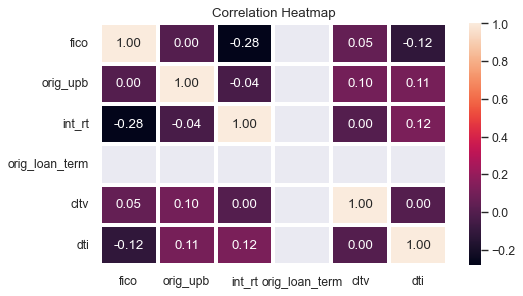

In [45]:
sns.set(rc={'figure.figsize': (7, 4)})
sns.heatmap(X_train_clean[num_var].corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()

`orig_loan_term` is constant, all entries have 360 scheduled monthly payments from the First Payment Date to the Maturity Date.

**Categorical variables**: Below displays the bar charts of all categorical variables.

In [46]:
# Identifiers variables are: 'id_loan','cd_msa','zipcode'
# Long categorical variables are: 'st', 'servicer_name', 'seller_name'
# Numerical variables are: 'fico', 'orig_upb', 'int_rt','cltv','dti','cltv'
exclude_var = ['id_loan','cd_msa','zipcode','st', 'servicer_name', 'seller_name','fico', 'orig_upb', 'int_rt','cltv', 'ltv', 'dti']

columns_to_plot = [col for col in X_train_clean.columns if col not in exclude_var + ['flag_sc', 'ppmt_pnlt', 'dt_matr', 'dt_first_pi']]

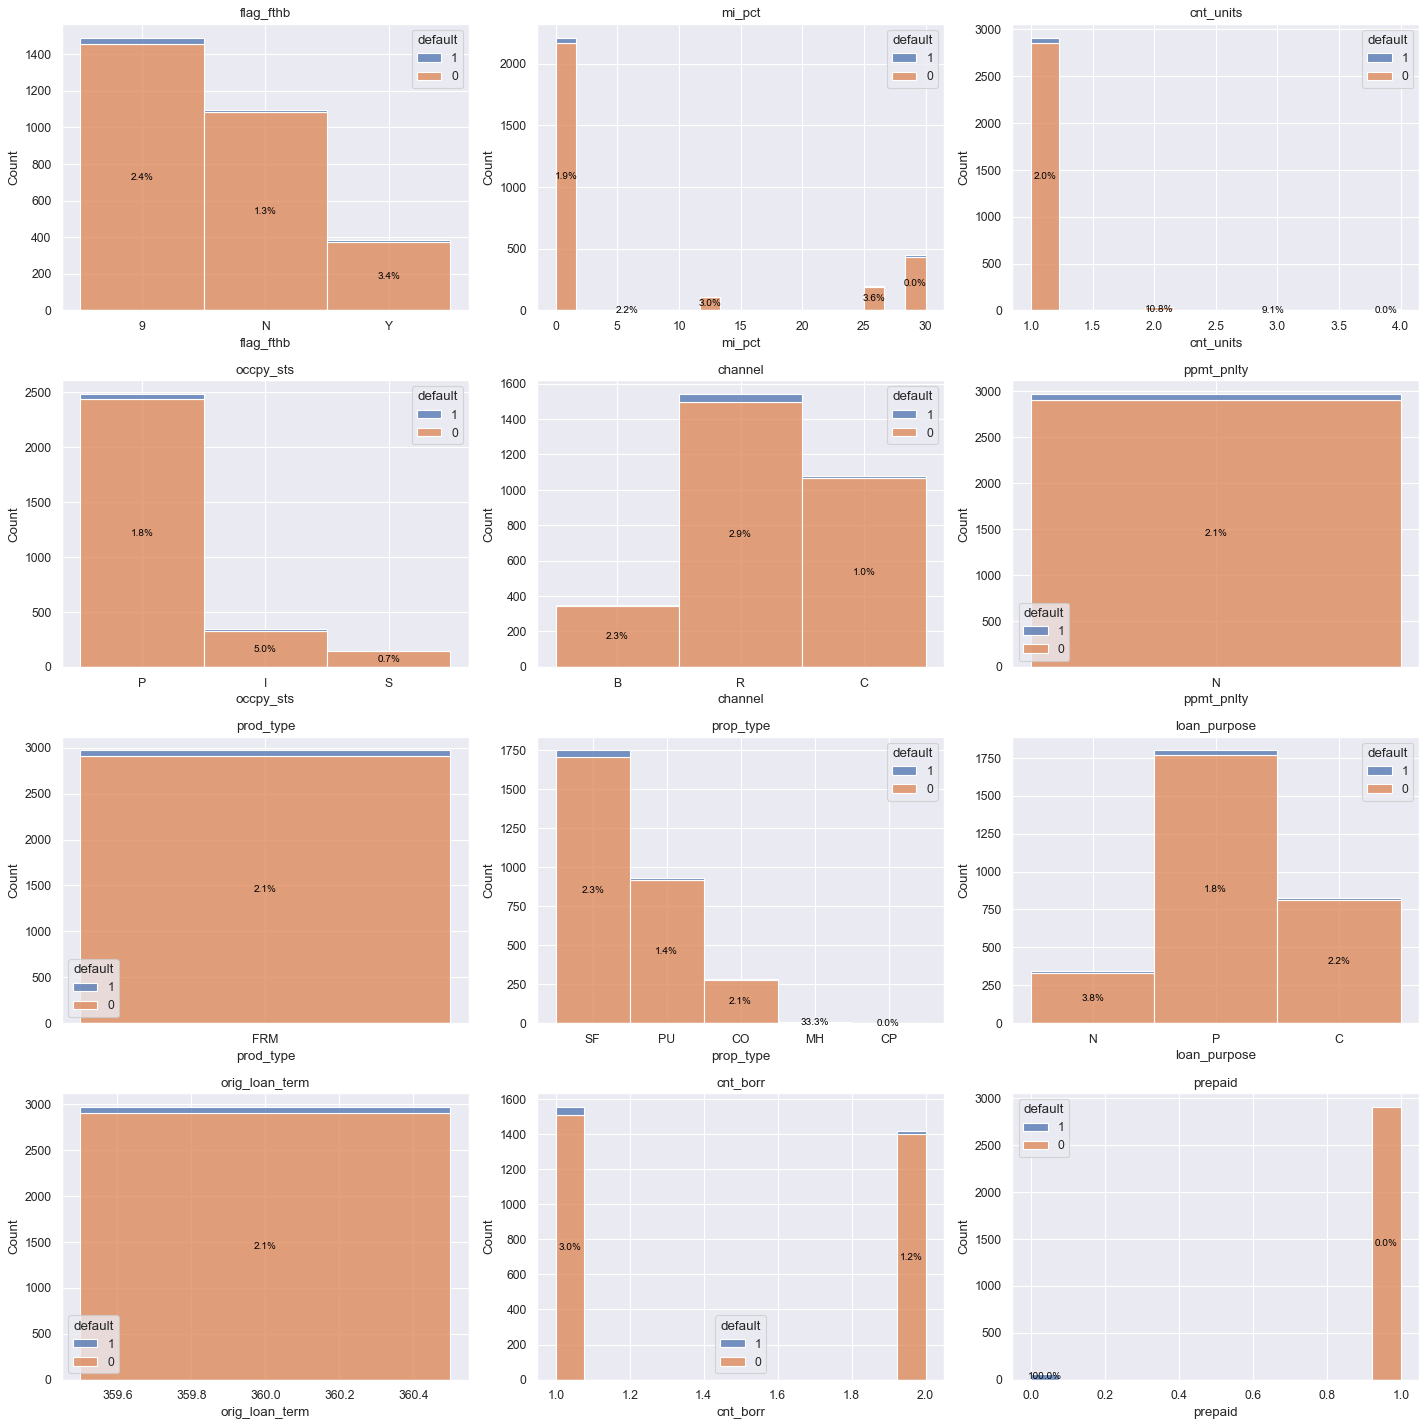

In [47]:
data = pd.concat([X_train_clean[columns_to_plot].astype('object'), pd.DataFrame(y_train_clean)], axis=1).dropna()
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    ax = sns.histplot(data=data, x=column, hue='default', multiple='stack', hue_order=[1, 0], ax=axes[i])
    axes[i].set_title(f'{column}')

    # Calculate the counts for each category within the column
    category_order = data[column].dropna().unique()
    counts_total = data[column].value_counts().reindex(category_order).fillna(0) 
    counts_default_1 = data[data['default'] == 1][column].value_counts().reindex(category_order).fillna(0)

    # Calculate the percentages
    percentages = 100 * counts_default_1 / counts_total

    # Iterate over the bars for the current axis
    bar_patches = [p for p in ax.patches if p.get_height() > 0]  # Only consider bars with height > 0
    for j, bar in enumerate(bar_patches[:len(category_order)]):  
        # The percentage for the category is at the same position as the bar
        percentage = percentages.iloc[j]
        # Annotate the percentage in the middle of the bar
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{percentage:.1f}%', 
                ha='center', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()



In [48]:
pd.DataFrame(y_train).value_counts()

default
0          4193
1            79
dtype: int64

Below, we examine the relationship between defaults and zipcode. We found that zipcode is not very relevant to default rate.

In [49]:
data = pd.concat([X_train_clean['zipcode'].astype('object'), pd.DataFrame(y_train_clean)], axis=1).dropna()

zipcode_counts = data['zipcode'].value_counts()

top_20_zipcodes = zipcode_counts.head(20).index

top_zipcodes_data = data[data['zipcode'].isin(top_20_zipcodes)]

default_percentages = top_zipcodes_data.groupby('zipcode')['default'].agg(
    total_defaults='sum',   
    total='count',          
)

default_percentages['default_percentage'] = default_percentages['total_defaults'] / default_percentages['total']

top_zipcodes_default_percentage = default_percentages.sort_values('default_percentage', ascending=False)
print(top_zipcodes_default_percentage)

         total_defaults  total  default_percentage
zipcode                                           
95300                 2     22            0.090909
75000                 2     34            0.058824
80000                 1     21            0.047619
92500                 1     23            0.043478
89100                 1     24            0.041667
92000                 1     27            0.037037
30000                 1     29            0.034483
94500                 1     45            0.022222
98000                 0     34            0.000000
95600                 0     32            0.000000
92600                 0     25            0.000000
91300                 0     23            0.000000
91700                 0     27            0.000000
37000                 0     21            0.000000
85300                 0     38            0.000000
85200                 0     49            0.000000
84000                 0     36            0.000000
80200                 0     23 

Below, we examine the relationship between the number of defaults and whether the borrower is a first-time homebuyer.

In [50]:
def default_percentages(var_name):
    var_data = X_train_clean[var_name].astype('object').fillna('Missing')

    data = pd.concat([var_data, pd.DataFrame(y_train_clean)], axis=1)

    default_percentages = data.groupby(var_name)['default'].agg(
    total_defaults='sum',   
    total='count',          
    )

    default_percentages['default_percentage'] = default_percentages['total_defaults'] / default_percentages['total']
    print(default_percentages.sort_values('default_percentage', ascending=False))


In [51]:
default_percentages('flag_fthb')

           total_defaults  total  default_percentage
flag_fthb                                           
Y                      13    385            0.033766
9                      36   1499            0.024016
N                      14   1111            0.012601


**identifiers** `id_loan` is an unique identifiers with no duplicates in this dataset. On the contrary, `zipcode` is not an unique identifier, observations are 5-digit area codes. Similarly, `cd_msa` are 5-digit codes of Metropolitan Statistical Area (MSA) regions, where the complete list of regions can be found [here](https://www2.census.gov/programs-surveys/cps/methodology/Geographic%20Coding%20-%20Metro%20Areas%20(since%20August%202005).pdf).


In [52]:
# Check for duplicates in 'id_loan' variable
duplicates = d[d.duplicated(subset=['id_loan'], keep=False)]

if not duplicates.empty:
    print("Duplicates found in 'id_loan' variable:")
    print(duplicates)
else:
    print("No duplicates found in 'id_loan' variable.")

d['zipcode_str'] = d['zipcode'].astype(str)

No duplicates found in 'id_loan' variable.


**Feature Engineering** 
Will be implemented using pipelines below.

| Variable Name      | Feature Engineering |
|--------------------|---------------------|
| `flag_fthb`          | replace all 9s with NaN and map Y as 1, N as 0.       |
| `cnt_units`         | One-hot encoding 4 levels: 1,2,3,4.       |
| `occpy_sts`         | One-hot encoding 3 levels: P,S,I.       |
| `cltv`, `dti`,`ltv`             | discard 1 NA.|
| `channel`             | One-hot encoding 4 levels: R,B,C,T.                |
| `ppmy_pnlty`             | disccard all NaN, map Y as 1, N as 0. Note there's no Y in this dataset.               |
| `prod_type`            | discard this feature, all observations are "FRM" (fixed-rate mortgage). Have no predictive power to adjustable-rate mortgage.|
| `prop_type`             | One-hot encoding to 5 levels: 'SF' 'PU' 'MH' 'CO' 'CP'.                 |
| `loan_purpose`            | One-hot encoding to 4 levels: C,N,R,P.                |
| `cnt_bnrr`            |  Map 1($1$ borrower) to 0 and 2( $>1$ borrower) to 1.|
| `flag_sc`            | discard this feature, all observations are either Y or NaN. Have no predictive power.                |

In [7]:
class CleanDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, value_to_replace):
        self.value_to_replace = value_to_replace

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.replace(self.value_to_replace, np.nan)

class IQRBasedOutlierRemoverEnhanced(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5, remove_outliers=False):
        self.factor = factor
        self.remove_outliers = remove_outliers

    def fit(self, X, y=None):
        # Compute the IQR bounds
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        self.lower_bounds_ = Q1 - self.factor * IQR
        self.upper_bounds_ = Q3 + self.factor * IQR
        return self

    def transform(self, X):
        if self.remove_outliers:
            # Apply the mask for the bounds to the data
            mask = (X >= self.lower_bounds_) & (X <= self.upper_bounds_)
            return X[mask]
        else:
            # Mark outliers as NaN
            mask_lower = (X < self.lower_bounds_)
            mask_upper = (X > self.upper_bounds_)
            X_copy = X.copy()
            X_copy[mask_lower | mask_upper] = np.nan
            return X_copy
            
       
class AutoBinaryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, val1='N', val2='Y'):
        self.val1 = val1
        self.val2 = val2
        
    def fit(self, X, y=None):
        # Dictionary to store mappings for each column
        self.mappings_ = {}
        for col in X.columns:
            self.mappings_[col] = {self.val1: "0", self.val2: "1"}
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col, mapping in self.mappings_.items():
            X_copy[col] = X_copy[col].map(mapping)
        return X_copy

class DropColumnsTransformer:
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns)

The sixteen **features selected** below will be used to train our models. They are split into numerical and categorical features, which will be processed using our helper function preprocessing.

In [8]:
num_features = ['fico', 'orig_upb', 'int_rt','orig_loan_term','cltv','dti']
#cat_features = X_train_clean.columns.drop(num_features)
#cat_features = ['flag_fthb', 'flag_sc','cnt_borr','loan_purpose','prop_type','ppmt_pnlty','prod_type']
cat_features = X.columns.drop(num_features+['prepaid', 'flag_sc', 'dt_first_pi', 'id_loan', 'cd_msa',
 'dt_matr', 'seller_name','servicer_name', 'ltv', 'zipcode'])

In [9]:
num_pre1 = Pipeline(steps=[
    ('num_clean', CleanDataTransformer(value_to_replace='999')),
    ("num_outliers", IQRBasedOutlierRemoverEnhanced(remove_outliers=False)),
    ("num_impute", SimpleImputer(strategy="median")),
    ("num_scale", StandardScaler())])

num_pre2 = Pipeline(steps=[
    ("num_outliers", IQRBasedOutlierRemoverEnhanced(remove_outliers=False)),
    ("num_impute", SimpleImputer(strategy="median")),
    ("num_scale", StandardScaler())])

cat_pre1 = Pipeline(steps=[
    ('cat_clean', CleanDataTransformer(value_to_replace='9')),
    ('cat_binary_encode', AutoBinaryEncoder()),
    ("cat_impute", SimpleImputer(strategy="constant", fill_value="missing")),
    ("cat_encode", OneHotEncoder(drop='first'))])

cat_pre2 = Pipeline(steps=[
    ('cat_binary_encode', AutoBinaryEncoder(val1='1', val2='2')),
    ("cat_impute", SimpleImputer(strategy="constant", fill_value="missing")),
    ("cat_encode", OneHotEncoder(drop='first'))])

#cat_pre3 = Pipeline(steps=[
#    ("cat_impute", SimpleImputer(strategy="constant", fill_value="missing")),
#    ("cat_encode", OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))])
cat_pre3 = Pipeline(steps=[
    ("cat_impute", SimpleImputer(strategy="constant", fill_value="missing")),
    ("cat_encode", OneHotEncoder(drop='first', handle_unknown='ignore'))])

preprocessing = ColumnTransformer([
    ("num_pre1", num_pre1, ['cltv', 'dti']),
    ("num_pre2", num_pre2, [x for x in num_features if x not in {'cltv', 'dti'}]),
    ("cat_pre1", cat_pre1, ['flag_fthb']),
    ("cat_pre2", cat_pre2, ['cnt_borr']),
    ("cat_pre3", cat_pre3, [x for x in cat_features if x not in {"flag_fthb", "cnt_borr"}])],
    remainder='drop')

# Model Fitting and Tuning

In [10]:
d = pd.read_csv("freddiemac.csv")
X = d.drop(columns=['default'])
y = d['default']
X[cat_features] = X[cat_features].astype('object')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=99)

**Baseline Model** For the baseline model, we use a `DummyClassifier` to predict that all results are non-default. This serves as a baseline for comparing more advanced models. The balanced accuracy is $0.50$.

In [28]:
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

balanced_accuracy = balanced_accuracy_score(y_test, baseline.predict(X_test))

print(f'Balanced Accuracy: {balanced_accuracy:.2f}')

Balanced Accuracy: 0.50


# Logistic Regression Models

Below, we trained three logistic regression (LR) models using different techniques. The first model is a basic LR model trained on all six numerical variables, including credit score and debt-to-income ratio, and ten selected categorical features, including area code, mortgage seller name, and number of borrowers under the mortgage. Unless otherwise specified, all models below use these sixteen features for model training purposes.

The second model uses grid search to find the best combination of hyperparameters for the LR model. It employs 5-fold cross-validation (CV) to optimise the model's Recall score.

The third model applies oversampling to address class imbalance, particularly for 'default' is 'Yes'. Additionally, it optimises the regularisation parameter of the LR model by sampling uniformly from a logistic distribution.

**basic LR model**

In [ ]:
# logistic_pipe  = Pipeline([
#     ("pre_processing", preprocessing),
#     ("model", LogisticRegression())])

# logistic_pipe.fit(X_train, y_train)
# print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, logistic_pipe.predict(X_test)):.3f}')

**Logistic Regression with 5-fold CV**

In [ ]:
# param_grid_lr = {
#      'C': [0.01, 0.1, 1, 10, 100],  
#      'penalty': ['l1', 'l2', 'elasticnet', 'none'],  
#      'solver': ['saga'],  
#      'class_weight': [None, 'balanced'],  
#      'l1_ratio': [None, 0.5]  
#  }
# 
# lr = LogisticRegression(random_state=69, max_iter=100000)
# 
# lr_cv_pipe = Pipeline([
#      ("pre_processing", preprocessing),
#      ("scaler", StandardScaler()),
#      ("model", GridSearchCV(
#          estimator=lr,
#          param_grid=param_grid_lr,
#          cv=5,
#          scoring='recall',
#          n_jobs=-1,
#          verbose=2))
#  ])
# 
# lr_cv_pipe.fit(X_train, y_train)


**Logistic Regression with Oversampling+CV**

In [ ]:
# logistic_pipe3  = ImPipeline([
#     ("pre_processing", preprocessing),
#     ("scaler", StandardScaler()),
#     ("sampler", RandomOverSampler(random_state=69)),
#     ("model", LogisticRegression(random_state=69, max_iter=10000))])



# log_param_dist2 = {'model__C':loguniform(C_list[0], C_list[-1]),}

# os_log_rs2 = RandomizedSearchCV(logistic_pipe3, 
#                             param_distributions = log_param_dist2,
#                             n_iter = 60, 
#                             scoring = ["balanced_accuracy", "f1","recall","precision"], 
#                             cv = StratifiedKFold(n_splits = 5),
#                             refit = "recall", 
#                             random_state = 69,
#                             return_train_score = True)

# os_log_rs2.fit(X_train, y_train)

# Random Forest Models

Random Forest models provide feature selection by calculating feature importances during the training process. Below, we trained three Random Forest (RF) models using different techniques. The first is a basic RF model trained on all sixteen variables; the second model uses grid search to optimise the hyperparameters and uses 5-fold CV to optimise Recall. Additionally, the third model applies oversampling and uses CV to optimise balanced accuracy.

**basic RF model**

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(max_depth = 10, random_state=69, oob_score=True, n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features='sqrt')

# rf_pipe = Pipeline([
#     ("pre_processing", preprocessing),
#     ("model", rf)])

# rf_pipe.fit(X_train, y_train)

# print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, rf_pipe.predict(X_test)):.2f}')

**RF with 5-fold CV**

In [ ]:
# param_grid = {
#     'n_estimators': [10, 50, 100, 200], 
#     'criterion': ['gini', 'entropy'], 
#     'max_depth': [None, 10, 20, 30],  
#     'min_samples_split': [2, 5, 10], 
#     'min_samples_leaf': [1, 2, 4],  
#     'max_features': ['sqrt', 'log2'], 
#     'bootstrap': [True, False],  
#     'class_weight': [None, 'balanced', 'balanced_subsample'],  
# }

# rf = RandomForestClassifier(random_state=69)

# rf_cv_pipe = Pipeline([
#     ("pre_processing", preprocessing),
#     ("model", GridSearchCV(estimator=rf, param_grid=param_grid, cv=5,
#                           scoring='recall', n_jobs=-1, verbose=1))])

# rf_cv_pipe.fit(X_train, y_train)

# print(f"Best parameters: {rf_cv_pipe['model'].best_params_}")


**RF with Oversampling+CV**

In [ ]:
# param_grid2 = {
#     'model__n_estimators': [10, 50, 100, 200], 
#     'model__criterion': ['gini', 'entropy'], 
#     'model__max_depth': [None, 10, 20, 30],  
#     'model__min_samples_split': [2, 5, 10], 
#     'model__min_samples_leaf': [1, 2, 4],  
#     'model__max_features': ['sqrt', 'log2'], 
#     'model__bootstrap': [True, False],  
#     'model__class_weight': [None, 'balanced', 'balanced_subsample']}

# os_rf_pipe2  = ImPipeline([
#     ("pre_processing", preprocessing),
#     ("sampler", RandomOverSampler(random_state=69)),
#     ("model", RandomForestClassifier(random_state=69))])

# os_rf_cv2 = RandomizedSearchCV(os_rf_pipe2, 
#                             param_distributions = param_grid2,
#                             n_iter = 60, 
#                             scoring = ["balanced_accuracy", "f1","recall","precision"], 
#                             cv = StratifiedKFold(n_splits = 5),
#                             refit = "balanced_accuracy", 
#                             random_state = 69,
#                             return_train_score = True,
#                             n_jobs=-1)

# os_rf_cv2.fit(X_train, y_train)

# Support Vector Machine

The Support Vector Classifier (SVC) offers several benefits, such as its ability to capture non-linear relationships between predictors and its reduced susceptibility to overfitting, particularly in our high-dimensional case. Again, we trained three models, noting that the last model oversampled default = Yes to resolve class imbalance issue, then uses optimised hyperparameters defined in `param_grid` and employs 5-fold CV to refit the model and optimise the recall score.

**basic SVC model**

In [ ]:
# from sklearn.svm import SVC         

# svc_pipe = Pipeline([
#     ("pre_processing", preprocessing),
#     ("model", SVC(random_state=69))])

# svc_pipe.fit(X_train, y_train)
# print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, svc_pipe.predict(X_test)):.4f}')

**SVC with 5-fold CV**

In [ ]:
# svc_cv_pipe = Pipeline([
#     ("pre_processing", preprocessing),
#     ("model", GridSearchCV(SVC(random_state=69),
#                            param_grid = { 
#                                     'kernel':('poly', 'linear', 'rbf'), 
#                                     'C': np.linspace(0.1, 10, 100),
#                                     'degree': [2,3,4]},
#                            cv = StratifiedKFold(n_splits=5),
#                            scoring='recall', n_jobs=-1))])

# svc_cv_pipe.fit(X_train, y_train)


**SVC with Oversampling+CV**

In [ ]:
# os_svc_pipe2  = ImPipeline([
#     ("pre_processing", preprocessing),
#     ("sampler", RandomOverSampler(random_state=69)),
#     ("model", SVC(random_state=69))])

# param_grid = {'model__kernel':('poly', 'linear', 'rbf'), 
#               'model__C': np.linspace(0.1, 10, 100),
#               'model__degree': [2,3,4]}

# os_svc_cv = RandomizedSearchCV(os_svc_pipe2, 
#                             param_distributions = param_grid,
#                             n_iter = 60, 
#                             scoring = ["balanced_accuracy", "f1","recall","precision"], 
#                             cv = StratifiedKFold(n_splits = 5),
#                             refit = "recall", 
#                             random_state = 69,
#                             return_train_score = True,
#                             n_jobs=-1)

# os_svc_cv.fit(X_train, y_train)

# Gradient Boost

**basic GB model**

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier

# gb_pipe = Pipeline([
#     ("pre_processing", preprocessing),
#     ("model", GradientBoostingClassifier())])

# gb_pipe.fit(X_train, y_train)
# print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, gbrf.predict(X_test)):.4f}')

**GB with 5-fold CV**

In [ ]:
# param_grid_gb = {
#     'n_estimators': [10, 50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2, 0.5],
#     'max_depth': [3, 5, 10, None],  
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],
# }

# gb = GradientBoostingClassifier(random_state=69)

# gb_cv_pipe = Pipeline([
#     ("pre_processing", preprocessing),
#     ("model", GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=StratifiedKFold(n_splits = 5),
#                           scoring='recall', n_jobs=-1, verbose=2))
# ])

# gb_cv_pipe.fit(X_train, y_train)

**GB with Oversampling+CV**

In [ ]:
# os_gb_pipe  = ImPipeline([
#     ("pre_processing", preprocessing),
#     ("sampler", RandomOverSampler(random_state=69)),
#     ("model", GradientBoostingClassifier(random_state=69))])

# param_grid_gb = {
#     'model__n_estimators': [10, 50, 100, 200],
#     'model__learning_rate': [0.01, 0.1, 0.2, 0.5],
#     'model__max_depth': [3, 5, 10, None],  
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4],
#     'model__max_features': ['sqrt', 'log2', None]
# }

# os_gb_cv = RandomizedSearchCV(os_gb_pipe, 
#                             param_distributions = param_grid_gb,
#                             n_iter = 60, 
#                             scoring = ["balanced_accuracy", "f1","recall","precision"], 
#                             cv = StratifiedKFold(n_splits = 5),
#                             refit = "recall", 
#                             random_state = 69,
#                             return_train_score = True,
#                             n_jobs=-1)

# os_gb_cv.fit(X_train, y_train)

# Discussion & Conclusions

The three tables below compare model performances using metrics including Accuracy, Recall, Precision, F1 Score, and Balanced Accuracy. Recall is of particular interest in the context of mortgage default prediction, where minimising False Negatives is essential. A False Negative occurs when the model incorrectly predicts that a borrower won't default on their mortgage when they actually do. Maximising Recall enables lenders to accurately identify high-risk borrowers, empowering them to take proactive measures to mitigate potential losses.

Each table column highlights its maximum value in yellow. The first table shows the performances of the basic fitting, the second table shows the performances of models tuned for their optimal hyperparameters, and additionally, the third table takes into account oversampling to address class imbalance (considering the default rate of $1.85%$).

As displayed in the third and last table, during testing model 8 (GB OS CV) achieved the highest Recall score of $0.5294$. The best performed model is the **Gradient Boost(GB) model with oversampling(OS) and cross-validation (CV), refitted to optimise Recall**.

In [36]:
def output_result(model_names, models):
    accuracy_scores = [accuracy_score(y_test, m.predict(X_test)) for m in models]
    recall_scores = [recall_score(y_test, m.predict(X_test), average='binary') for m in models]
    precision_scores = [precision_score(y_test, m.predict(X_test), average='binary', zero_division=0) for m in models]
    f1_scores = [f1_score(y_test, m.predict(X_test), average='binary') for m in models]
    balanced_accuracy_scores = [balanced_accuracy_score(y_test, m.predict(X_test)) for m in models]

    results_df = pd.DataFrame({
        'Model Name': model_names,
        'Accuracy': accuracy_scores,
        'Recall': recall_scores,
        'Precision': precision_scores,
        'F1 Score': f1_scores,
        'Balanced Accuracy': balanced_accuracy_scores
    })

    format_dict = {
        'Accuracy': '{:.4f}',
        'Recall': '{:.4f}',
        'Precision': '{:.4f}',
        'F1 Score': '{:.4f}',
        'Balanced Accuracy': '{:.4f}'
    }

    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]

    styled_df = results_df.style.apply(highlight_max,
                                 subset=['Accuracy', 'Recall', 'Precision', 'F1 Score', 'Balanced Accuracy']).format(format_dict)
    return(styled_df)

In [30]:
basic_model_filenames = [f for f in os.listdir('models/basic/') if f.endswith('.joblib')]
basic_models = {filename.split('.joblib')[0]: load(os.path.join('models/basic/', filename)) for filename in basic_model_filenames}

baseline_model = basic_models.get('baseline_model')
gb_model = basic_models.get('gb_model')
lr_model = basic_models.get('lr_model')
rf_model = basic_models.get('rf_model')
svc_model = basic_models.get('svc_model')


In [12]:
balanced_accuracy_model_filenames = [f for f in os.listdir('models/balanced_accuracy/') if f.endswith('.joblib')]
balanced_accuracy_models = {filename.split('.joblib')[0]: load(os.path.join('models/balanced_accuracy/', filename)) for filename in balanced_accuracy_model_filenames}

gb_cv_model_acc, gb_os_cv_model_acc = balanced_accuracy_models.get('gb_cv_model'), balanced_accuracy_models.get('os_gb_cv_model')

lr_cv_model_acc, lr_os_cv_model_acc = balanced_accuracy_models.get('lr_cv_model'), balanced_accuracy_models.get('os_lr_cv_model')

rf_cv_model_acc, rf_os_cv_model_acc = balanced_accuracy_models.get('rf_cv_model'), balanced_accuracy_models.get('os_rf_cv_model')

svc_cv_model_acc, svc_os_cv_model_acc = balanced_accuracy_models.get('svc_cv_model'), balanced_accuracy_models.get('os_svc_cv_model')

In [13]:
recall_model_filenames = [f for f in os.listdir('models/recall/') if f.endswith('.joblib')]
recall_models = {filename.split('.joblib')[0]: load(os.path.join('models/recall/', filename)) for filename in recall_model_filenames}

gb_cv_model_rec, gb_os_cv_model_rec = recall_models.get('gb_cv_model'), recall_models.get('os_gb_cv_model')

lr_cv_model_rec, lr_os_cv_model_rec = recall_models.get('lr_cv_model'), recall_models.get('os_lr_cv_model')

rf_cv_model_rec, rf_os_cv_model_rec = recall_models.get('rf_cv_model'), recall_models.get('os_rf_cv_model')

svc_cv_model_rec, svc_os_cv_model_rec = recall_models.get('svc_cv_model'), recall_models.get('os_svc_cv_model')

**Table 1, Basic Models (without CV hyperparm tuning nor sampling)**

In [31]:
basic_model_name = ["Baseline", "Logistic Regression (LR)", "Random Forest (RF)", "Support Vector Classifier (SVC)", "Gradient Boosting (GB)"]
basic_models_ = [baseline_model, lr_model, rf_model, svc_model, gb_model]

output_result(basic_model_name, basic_models_)

,Model Name,Accuracy,Recall,Precision,F1 Score,Balanced Accuracy
0,Baseline,0.9814,0.0000,0.0000,0.0000,0.5000
1,Logistic Regression (LR),0.9814,0.0000,0.0000,0.0000,0.5000
2,Random Forest (RF),0.9814,0.0000,0.0000,0.0000,0.5000
3,Support Vector Classifier (SVC),0.9814,0.0000,0.0000,0.0000,0.5000
4,Gradient Boosting (GB),0.9771,0.0000,0.0000,0.0000,0.4978


**Table 2, Models with CV hyperparameter tuned and refitting by either balanced accuracy or recall**

In [32]:
cv_model_name = ["Baseline",
                 "LR_CV (Balanced Acc)", "LR_CV (Recall)",
                 "RF_CV (Balanced Acc)", "RF_CV (Recall)", 
                 "SVC_CV (Balanced Acc)", "SVC_CV (Recall)",
                 "GB_CV (Balanced Acc)", "GB_CV (Recall)"]

cv_models_ = [baseline_model, lr_cv_model_acc, lr_cv_model_rec, rf_cv_model_acc, rf_cv_model_rec,
             svc_cv_model_acc, svc_cv_model_rec, gb_cv_model_acc, gb_cv_model_rec]

output_result(cv_model_name, cv_models_)

,Model Name,Accuracy,Recall,Precision,F1 Score,Balanced Accuracy
0,Baseline,0.9814,0.0000,0.0000,0.0000,0.5000
1,LR_CV (Balanced Acc),0.9814,0.0000,0.0000,0.0000,0.5000
2,LR_CV (Recall),0.9814,0.0000,0.0000,0.0000,0.5000
3,RF_CV (Balanced Acc),0.8477,0.3235,0.0412,0.0731,0.5906
4,RF_CV (Recall),0.8477,0.3235,0.0412,0.0731,0.5906
5,SVC_CV (Balanced Acc),0.9776,0.0294,0.1111,0.0465,0.5125
6,SVC_CV (Recall),0.9776,0.0294,0.1111,0.0465,0.5125
7,GB_CV (Balanced Acc),0.9722,0.0882,0.1304,0.1053,0.5386
8,GB_CV (Recall),0.9749,0.0882,0.1667,0.1154,0.5399


**Table 3, Models with for oversampling the minority target class (defaults) with CV and refitting by either balanced accuracy or recall**

In [33]:
cv_os_model_name = ["Baseline",
                    "LR_OS_CV (Balanced Acc)", "LR_OS_CV (Recall)",
                    "RF_OS_CV (Balanced Acc)", "RF_OS_CV (Recall)", 
                    "SVC_OS_CV (Balanced Acc)", "SVC_OS_CV (Recall)",
                    "GB_OS_CV (Balanced Acc)", "GB_OS_CV (Recall)"]

cv_os_models_ = [baseline_model, lr_os_cv_model_acc, lr_os_cv_model_rec, rf_os_cv_model_acc, rf_os_cv_model_rec,
             svc_os_cv_model_acc, svc_os_cv_model_rec, gb_os_cv_model_acc, gb_os_cv_model_rec]

output_result(cv_os_model_name, cv_os_models_)

,Model Name,Accuracy,Recall,Precision,F1 Score,Balanced Accuracy
0,Baseline,0.9814,0.0000,0.0000,0.0000,0.5000
1,LR_OS_CV (Balanced Acc),0.8204,0.2941,0.0317,0.0573,0.5622
2,LR_OS_CV (Recall),0.7675,0.4412,0.0355,0.0658,0.6074
3,RF_OS_CV (Balanced Acc),0.8979,0.2353,0.0473,0.0788,0.5729
4,RF_OS_CV (Recall),0.8979,0.2353,0.0473,0.0788,0.5729
5,SVC_OS_CV (Balanced Acc),0.7451,0.4412,0.0324,0.0604,0.5960
6,SVC_OS_CV (Recall),0.7451,0.4412,0.0324,0.0604,0.5960
7,GB_OS_CV (Balanced Acc),0.9039,0.1765,0.0390,0.0638,0.5471
8,GB_OS_CV (Recall),0.6168,0.5294,0.0256,0.0488,0.5739


We **further fine-tune** the oversampling sample strategy for the minority class default = Yes using the best pipeline `gb_os_cv_model_rec`. The optimal sampling strategy is found to be $1.0$, indicating that the number of samples in this minority class will be equal to the number of samples in the majority class (default = No) after oversampling. With this tuned best model, the **recall** score remains at $0.5294$, indicating the model captures about $53\%$ of the actual defaults in the dataset. The **confusion matrix** reveals $1112$ True Negatives, $18$ True Positives, $16$ False Negatives, and $686$ False Positives.

The **feature importance plot** can be found below. In descending order, the most important features are: first-time home buyer, date of last payment, date of first payment, loan ID, and MSA area code. Other features are eliminated to zero importance.

In [24]:
from sklearn.model_selection import StratifiedKFold
best_pipeline = gb_os_cv_model_rec.best_estimator_

param_grid_gb = {
    'sampler__sampling_strategy': [0.3,0.5,0.75,1.0]
}

os_gb_cv_best = RandomizedSearchCV(best_pipeline, 
                              param_distributions=param_grid_gb,
                              n_iter=60, 
                              scoring=["balanced_accuracy", "f1", "recall", "precision"], 
                              cv=StratifiedKFold(n_splits=5),
                              refit="recall", 
                              random_state=69,
                              return_train_score=True,
                              n_jobs=-1)

os_gb_cv_best.fit(X_train, y_train)

/Users/margaretli/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/margaretli/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/margaretli/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/margaretli/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/margaretli/op

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('pre_processing',
                                              ColumnTransformer(transformers=[('num_pre1',
                                                                               Pipeline(steps=[('num_clean',
                                                                                                CleanDataTransformer(value_to_replace='999')),
                                                                                               ('num_outliers',
                                                                                                IQRBasedOutlierRemoverEnhanced()),
                                                                                               ('num_impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('num_s...
                   param_distributions={'model__learning_rate': [0.01, 0.1, 0.2,
                                                                 0.5],
                                        'model__max_depth': [3, 5, 10, None],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [10, 50, 100,
                                                                200],
                                        'sampler__sampling_strategy': [0.5,
                                                                       0.75,
                                                                       1.0]},
                   random_state=69, refit='recall', return_train_score=True,
                   scoring=['balanced_accuracy', 'f1', 'recall', 'precision'])

In [34]:
best_sampling_strategy = os_gb_cv_best.best_params_['sampler__sampling_strategy']
print("Best sampling strategy:", best_sampling_strategy)

Best sampling strategy: 1.0


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Predictions on the testing set
y_pred = os_gb_cv_best.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6168122270742358
Precision: 0.02556818181818182
Recall: 0.5294117647058824
F1 Score: 0.04878048780487805
ROC AUC Score: 0.5739383628868677
Confusion Matrix:
[[1112  686]
 [  16   18]]


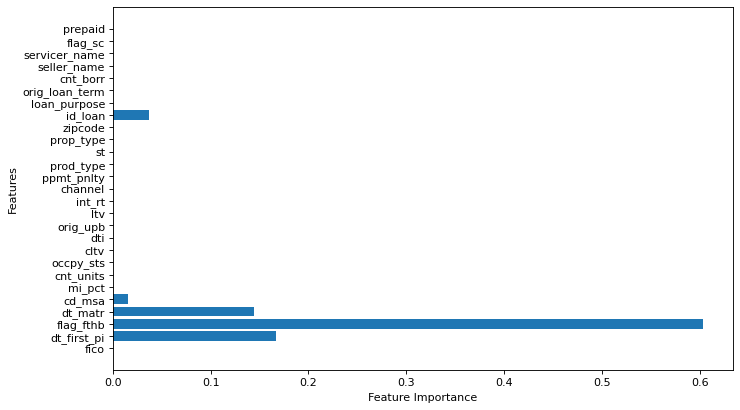

In [39]:
best_pipeline = gb_os_cv_model_rec.best_estimator_
best_gb_model = best_pipeline.named_steps['model']

feature_importances = best_gb_model.feature_importances_
feature_names = X_train.columns  

n = len(feature_names)
plt.figure(figsize=(10, 6))
plt.barh(range(n), feature_importances[:n], align='center')
plt.yticks(range(n), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()


# References

*Include references if any*

In [53]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

/bin/bash: jupyter: command not found


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a2a9ec8d-a343-4210-b36b-f9db26268fc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>